In [4]:
# filtering for nanosynteny?

In [2]:
from GenomicTools.tools import *
from GenomicTools.tandem_duplications import *
from GenomicTools.synteny import *
from GenomicTools.dot_plots import *
from GenomicTools.permutations import *

In [3]:
# spA, spB, dot_plot, dot_plot_labels = load_dot_plot('Giraffa_camelopardalis-Okapia_johnstoni-dotplot.csv.gz')
# spA, species_data_A, species_data_labels_A, chrom_info_A = load_species_data('Giraffa_camelopardalis_species_data.csv.gz')
# spB, species_data_B, species_data_labels_B, chrom_info_B = load_species_data('Okapia_johnstoni_species_data.csv.gz')

spA, spB, dot_plot, dot_plot_labels = load_dot_plot('Macaca_fuscata-Mandrillus_sphinx-dotplot.csv.gz')
spA, species_data_A, species_data_labels_A, chrom_info_A = load_species_data('Macaca_fuscata_species_data.csv.gz')
spB, species_data_B, species_data_labels_B, chrom_info_B = load_species_data('Mandrillus_sphinx_species_data.csv.gz')

In [31]:
dot_plot.shape[0], species_data_A.shape[0], species_data_B.shape[0]

(68611, 25076, 24952)

In [35]:
68611 / (25076 * 24952)

0.00010965542595971536

In [33]:
dot_plot.shape[0], species_data_A.shape[0], species_data_B.shape[0]

(1478558, 54735, 43070)

In [34]:
1478558 / (54735 * 43070)

0.0006271889110732974

In [4]:
rho, N_A, N_B = calculate_density(dot_plot,chrom_info_A,chrom_info_B)
kmin = k_min(.05, rho, N_A, N_B)

In [32]:
params = {}
params['dot_maxdist'] = 10
params['block_minsize'] = kmin
params['tandem_windowsize'] = 1
params['max_iterations'] = 3
params['block_overlap_threshold'] = 2

In [33]:
dist_cutoff = params['max_iterations'] * params['dot_maxdist']

In [7]:
from time import time

In [8]:
t0 = time()
chromsA = alphanum_sort(np.unique(dot_plot[:,0]))
chromsB = alphanum_sort(np.unique(dot_plot[:,2]))
maps_A = create_shift_map(species_data_A, params['tandem_windowsize'])
maps_B = create_shift_map(species_data_B, params['tandem_windowsize'])
shifted_dots = shift_dots(dot_plot, species_data_A, species_data_B, maps_A, maps_B)
t1 = time()

In [9]:
t1 - t0

58.66060280799866

In [34]:
chromA = chromsA[2]
chromB = chromsB[0]
shifted_dots_AB = shifted_dots[(shifted_dots[:,0] == chromA)*(shifted_dots[:,2] == chromB)]
print(shifted_dots_AB.shape)

(11323, 4)


In [35]:
convolved_dots_AB = identify_blocks_chrom_pair(shifted_dots_AB,params['block_minsize'],1,maps_A,maps_B)
print(np.vstack(convolved_dots_AB).shape)

(681, 4)


In [36]:
shifted_dots_AB = extend_dots(shifted_dots_AB, convolved_dots_AB, dist_cutoff)
print(shifted_dots_AB.shape)

(10261, 4)


In [37]:
dist_cutoff

30

In [38]:
extended_dots_AB = extend_dots(shifted_dots_AB, convolved_dots_AB, params['dot_maxdist'])
blocks_AB = identify_blocks_chrom_pair(extended_dots_AB,params['block_minsize'],params['dot_maxdist'],maps_A,maps_B)
# print(len(convolved_dots_AB),extended_dots_AB.shape[0],len(blocks_AB))
i = 0
while True:
    try:
        dots_blocks_AB = np.vstack(blocks_AB)
    except ValueError:
        break
    n_dots_in_blocks = dots_blocks_AB.shape[0]
    extended_dots_AB = extend_dots(shifted_dots_AB, blocks_AB, params['dot_maxdist'])
    blocks_AB = identify_blocks_chrom_pair(extended_dots_AB,params['block_minsize'],params['dot_maxdist'],maps_A,maps_B)
    dots_blocks_AB = np.vstack(blocks_AB)
    i += 1
    if dots_blocks_AB.shape[0] == n_dots_in_blocks:
        break

In [39]:
unshifted_blocks_AB = unshift_synteny_blocks(blocks_AB,maps_A,maps_B,3)

In [40]:
absolute_blocks = []
for block in unshifted_blocks_AB:
    absolute_block = []
    for b in block:
        absolute_block.append([abs_A[b[0]]+int(b[1]),abs_B[b[2]]+int(b[3])])
    absolute_blocks.append(np.vstack(absolute_block))

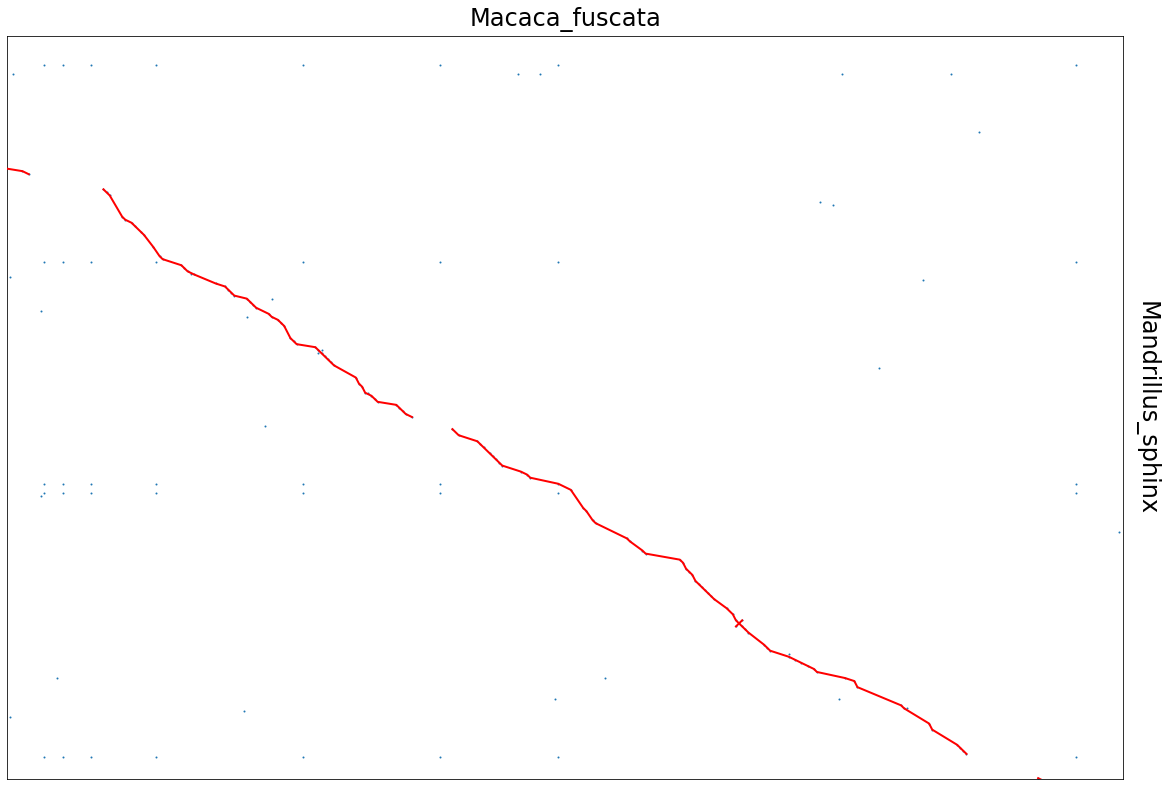

In [41]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xfrac_lim=[.05,.15],yfrac_lim=[.85,.95],label1=spA,label2=spB,synteny_blocks=absolute_blocks,dot_size=1,xlim=3,ylim=1)


In [20]:
chrom_locs1 = np.cumsum([0] + [chrom_info_A[key]['size'] for key in chrom_info_A.keys()])
chrom_locs2 = np.cumsum([0] + [chrom_info_B[key]['size'] for key in chrom_info_B.keys()])
abs_A = {alphanum_sort(chrom_info_A.keys())[n]:s for n, s in enumerate(chrom_locs1[:-1])}
abs_B = {alphanum_sort(chrom_info_B.keys())[n]:s for n, s in enumerate(chrom_locs2[:-1])}
abs_int_A = {n+1:s for n, s in enumerate(chrom_locs1[:-1])}
abs_int_B = {n+1:s for n, s in enumerate(chrom_locs2[:-1])}

In [5]:
params = {}
#params['tandem_windowsize'] = 1
params['dot_maxdist'] = 5
#params['condensed_block_minsize'] = 3
#params['nanosynteny_minsize'] = 3
params['block_minsize'] = kmin
#params['block_overlap_threshold'] = 2
#params['large_block_dot_threshold'] = 2
#params['max_iterations'] = 20

In [6]:
blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,params)

In [7]:
absolute_blocks = []
for block in blocks:
    absolute_block = []
    for b in block:
        absolute_block.append([abs_int_A[b[0]]+int(b[1]),abs_int_B[b[2]]+int(b[3])])
    absolute_blocks.append(np.vstack(absolute_block))

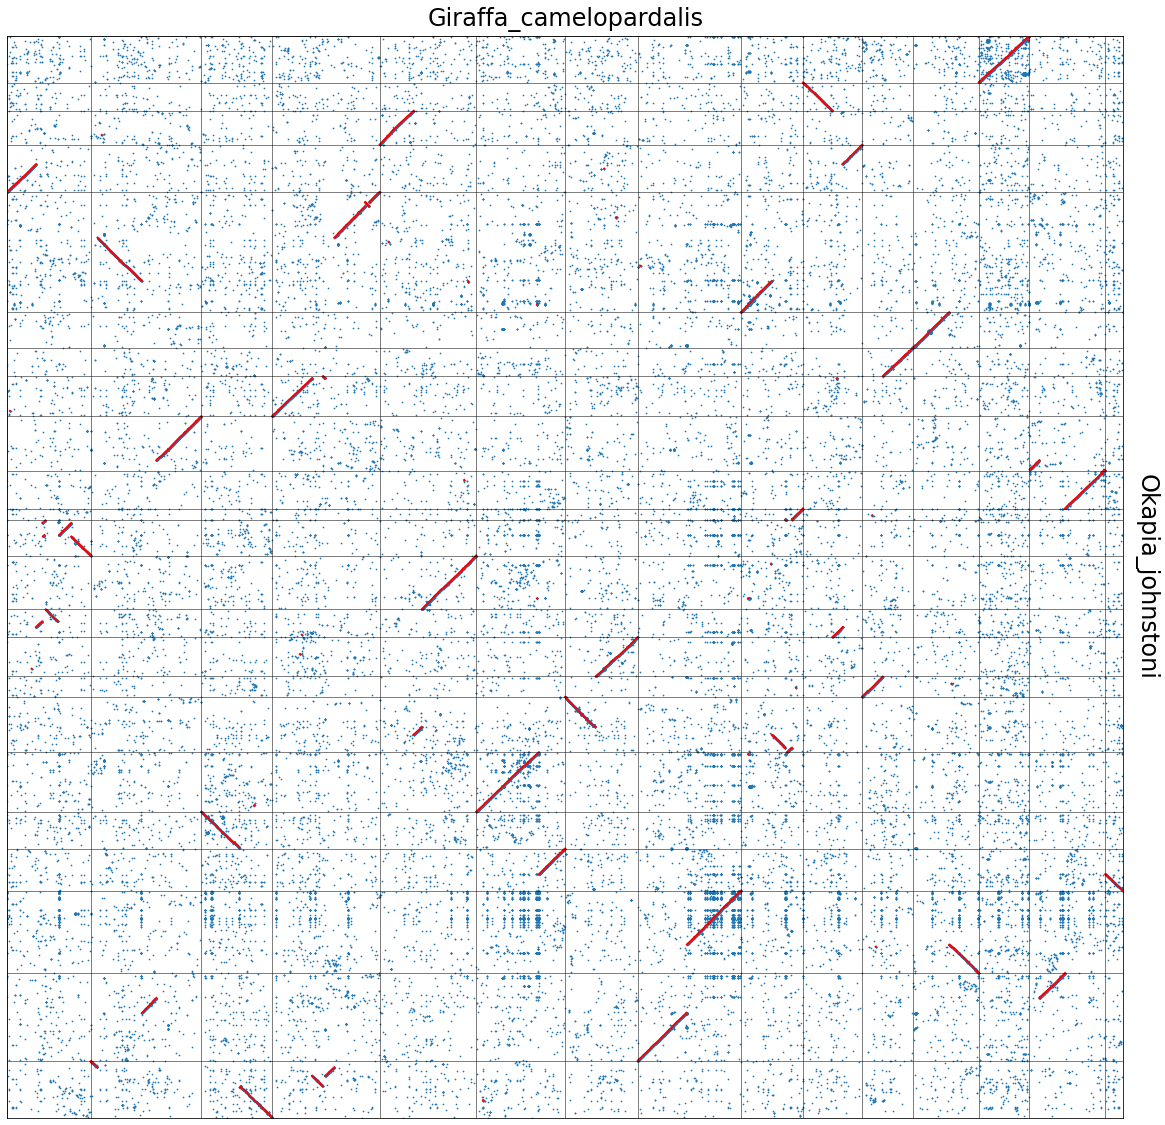

In [8]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,block_color='r',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


In [12]:
absolute_blocks = []
for block in fixed_blocks:
    absolute_block = []
    for b in block:
        absolute_block.append([abs_int_A[b[0]]+int(b[1]),abs_int_B[b[2]]+int(b[3])])
    absolute_blocks.append(np.vstack(absolute_block))

# absolute_blocks = []
# for block in blocks:
#     absolute_block = []
#     for b in block:
#         absolute_block.append([abs_A[b[0]]+int(b[1]),abs_B[b[2]]+int(b[3])])
#     absolute_blocks.append(np.vstack(absolute_block))

# absolute_blocks = []
# for block in blocks:
#     absolute_block = []
#     for b in block:
#         absolute_block.append([abs_int_A[b[0]]+b[1],abs_int_B[b[2]]+b[3]])
#     absolute_blocks.append(np.vstack(absolute_block))

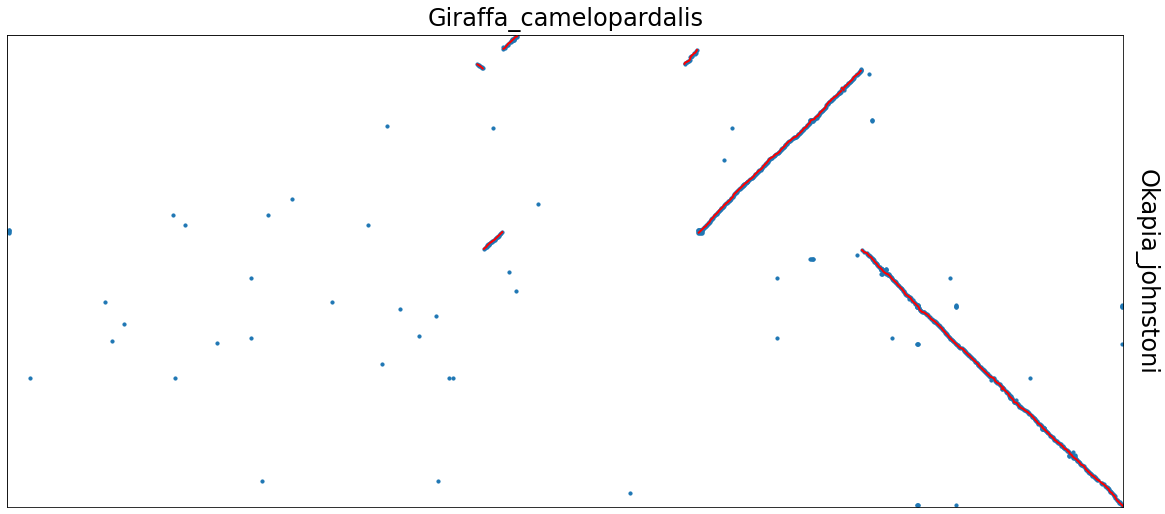

In [12]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=1,ylim=12,xfrac_lim=[0,1],yfrac_lim=[0,1],dot_size=10,block_color='r',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


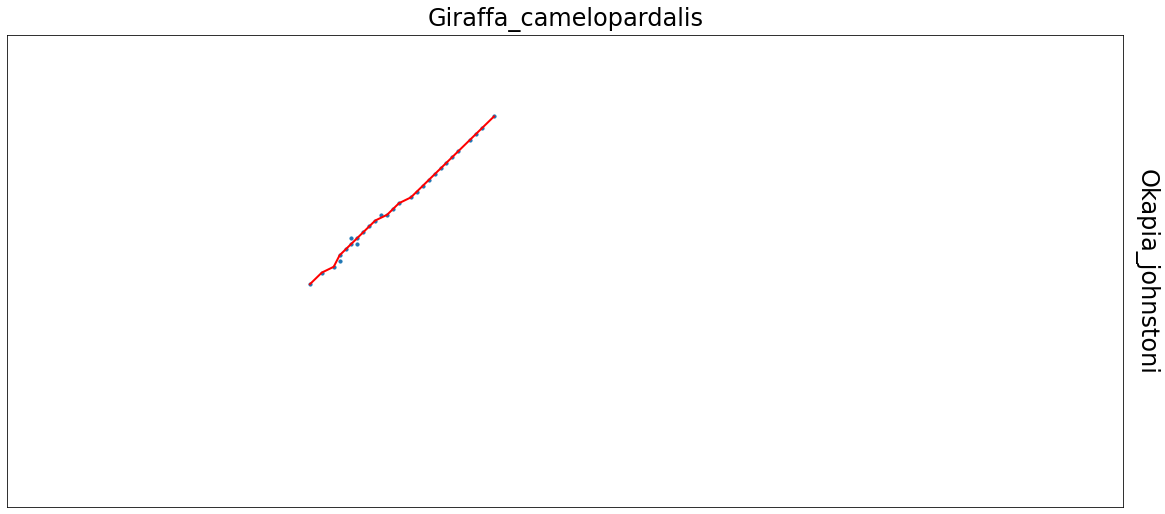

In [9]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=1,ylim=12,xfrac_lim=[.4,.5],yfrac_lim=[.5,.6],dot_size=10,block_color='r',synteny_blocks=absolute_blocks,label1=spA,label2=spB)

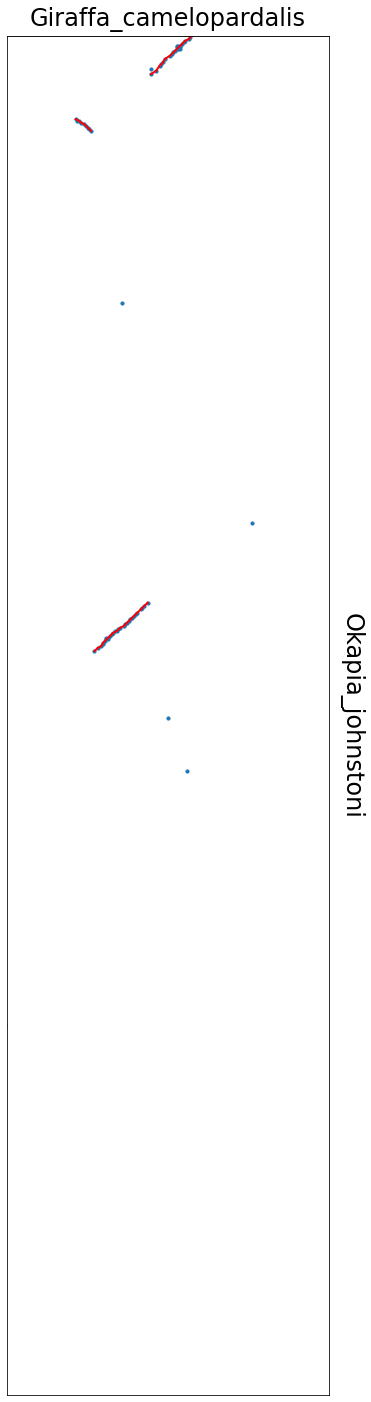

In [10]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=1,ylim=12,xfrac_lim=[.4,.5],yfrac_lim=[0,1],dot_size=10,block_color='r',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


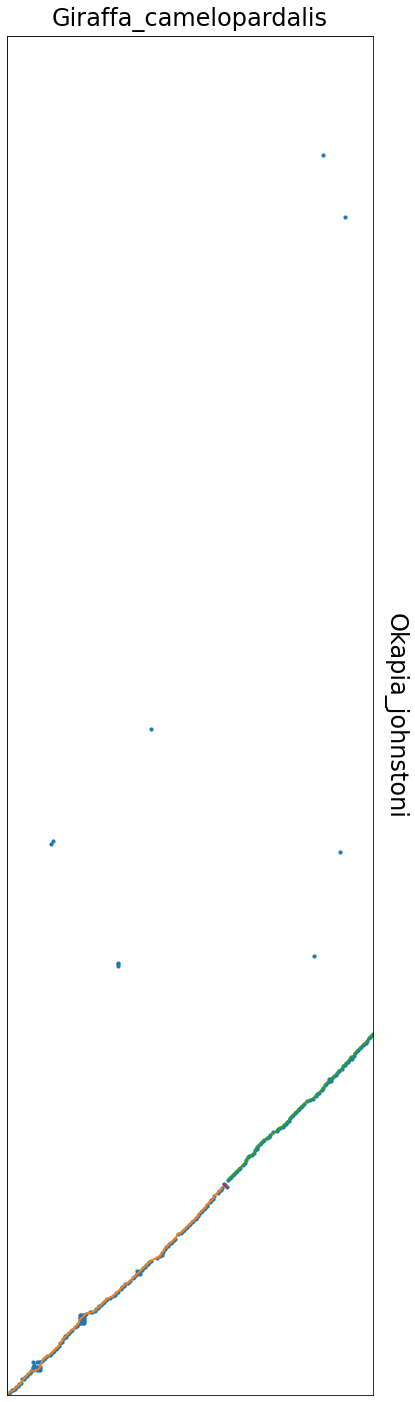

In [11]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=4,ylim=16,xfrac_lim=[0,.1],yfrac_lim=[0,1],dot_size=10,block_color='many',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


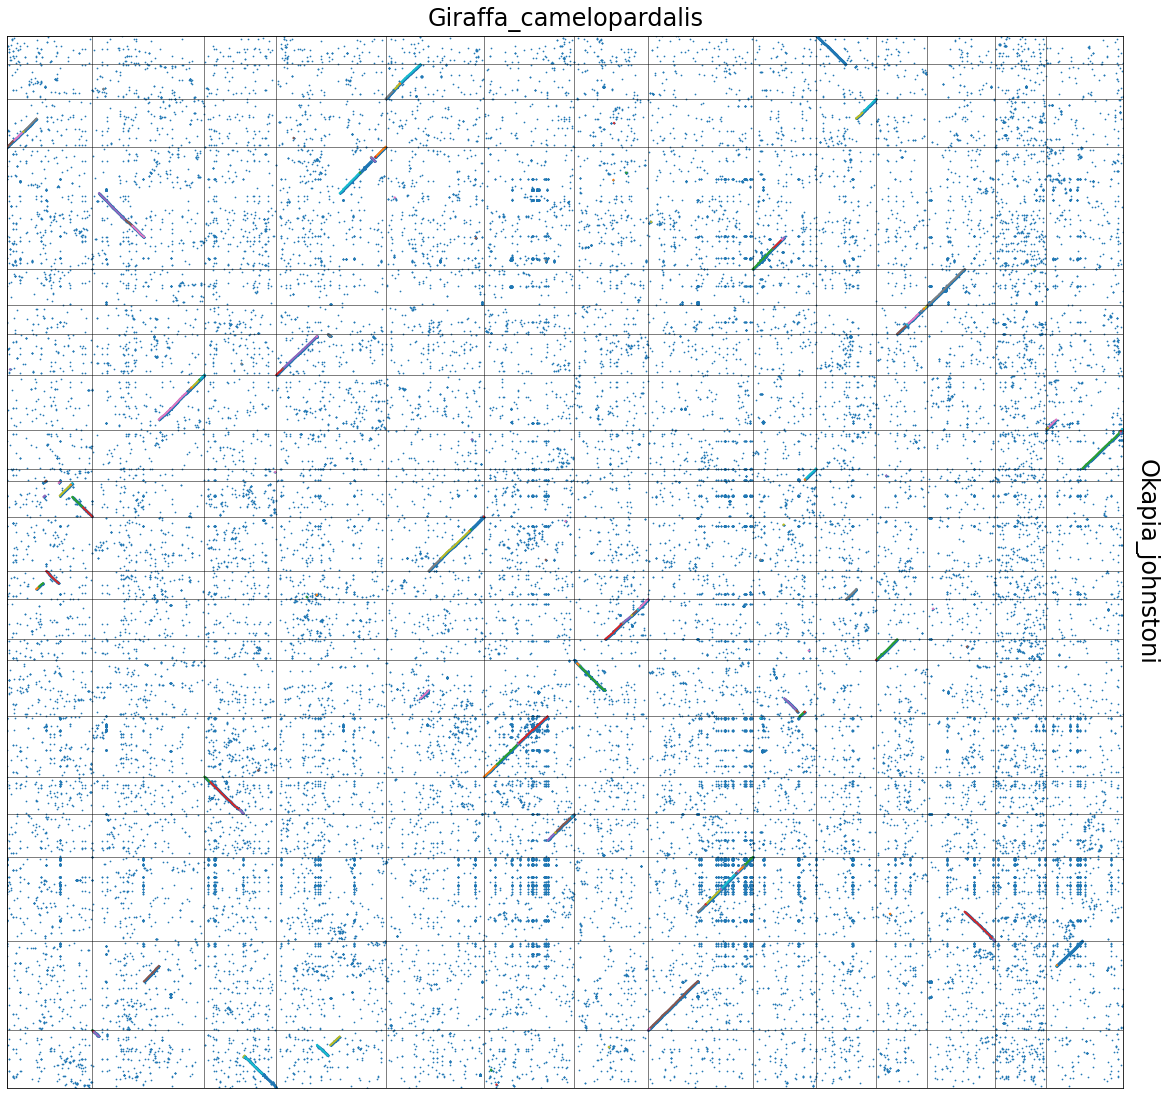

In [18]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,block_color='many',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


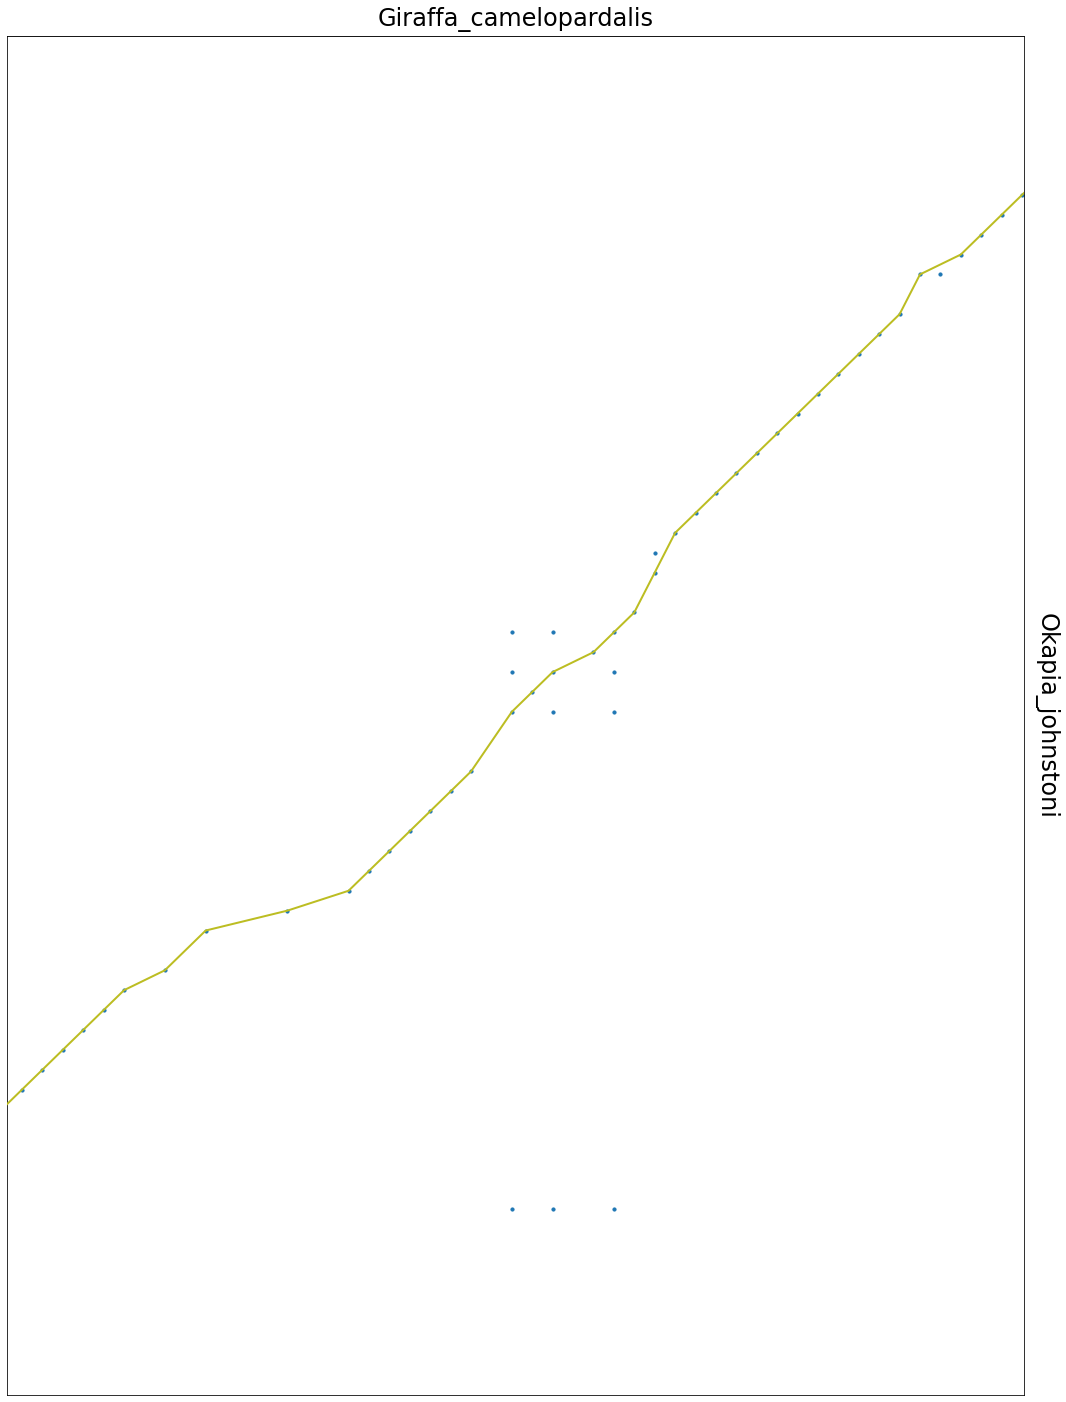

In [12]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=6,ylim=6,xfrac_lim=[.675,.7],yfrac_lim=[.95,1],dot_size=10,block_color='many',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


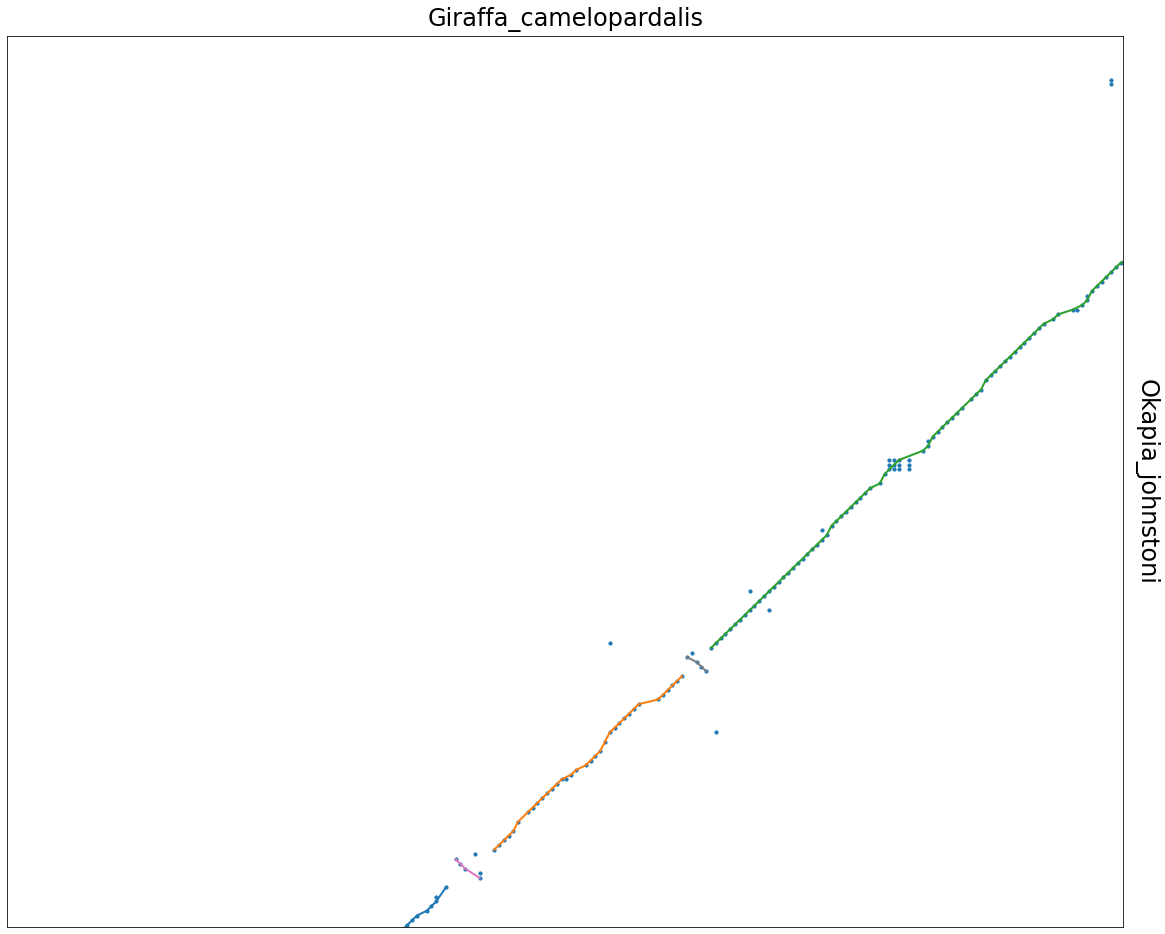

In [13]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=8,ylim=3,xfrac_lim=[.8,.9],yfrac_lim=[.8,.9],dot_size=10,block_color='many',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


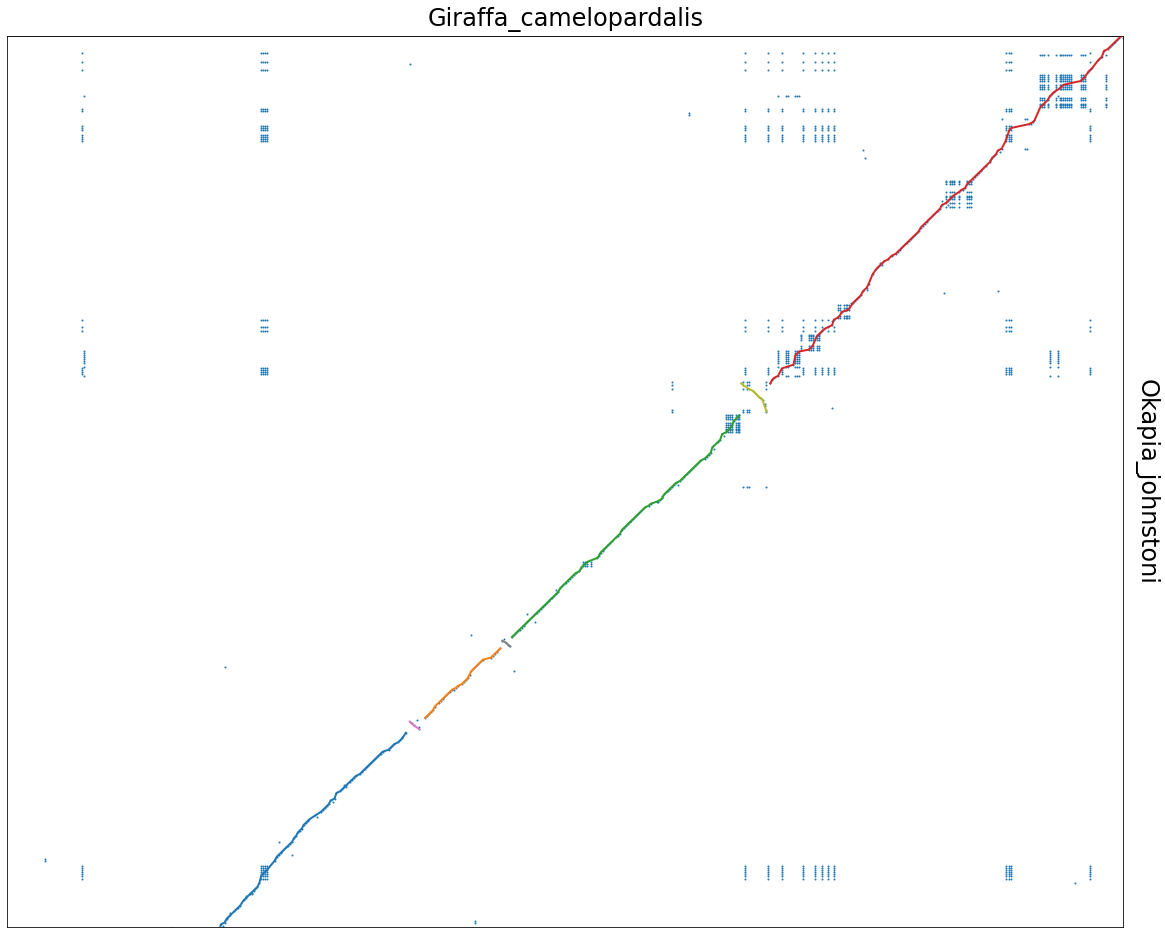

In [14]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=8,ylim=3,xfrac_lim=[.75,1],yfrac_lim=[.75,1],dot_size=1,block_color='many',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


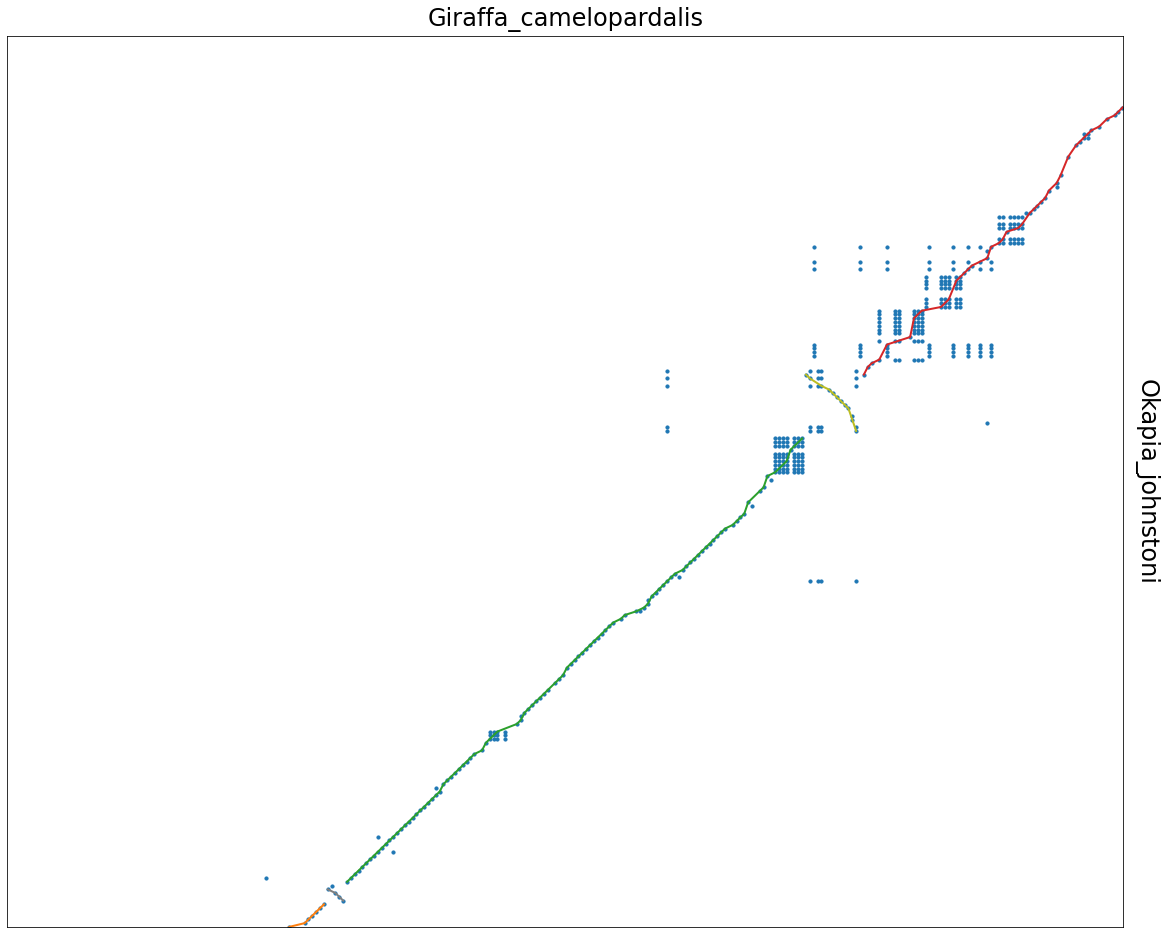

In [15]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,xlim=8,ylim=3,xfrac_lim=[.825,.95],yfrac_lim=[.825,.95],dot_size=10,block_color='many',synteny_blocks=absolute_blocks,label1=spA,label2=spB)


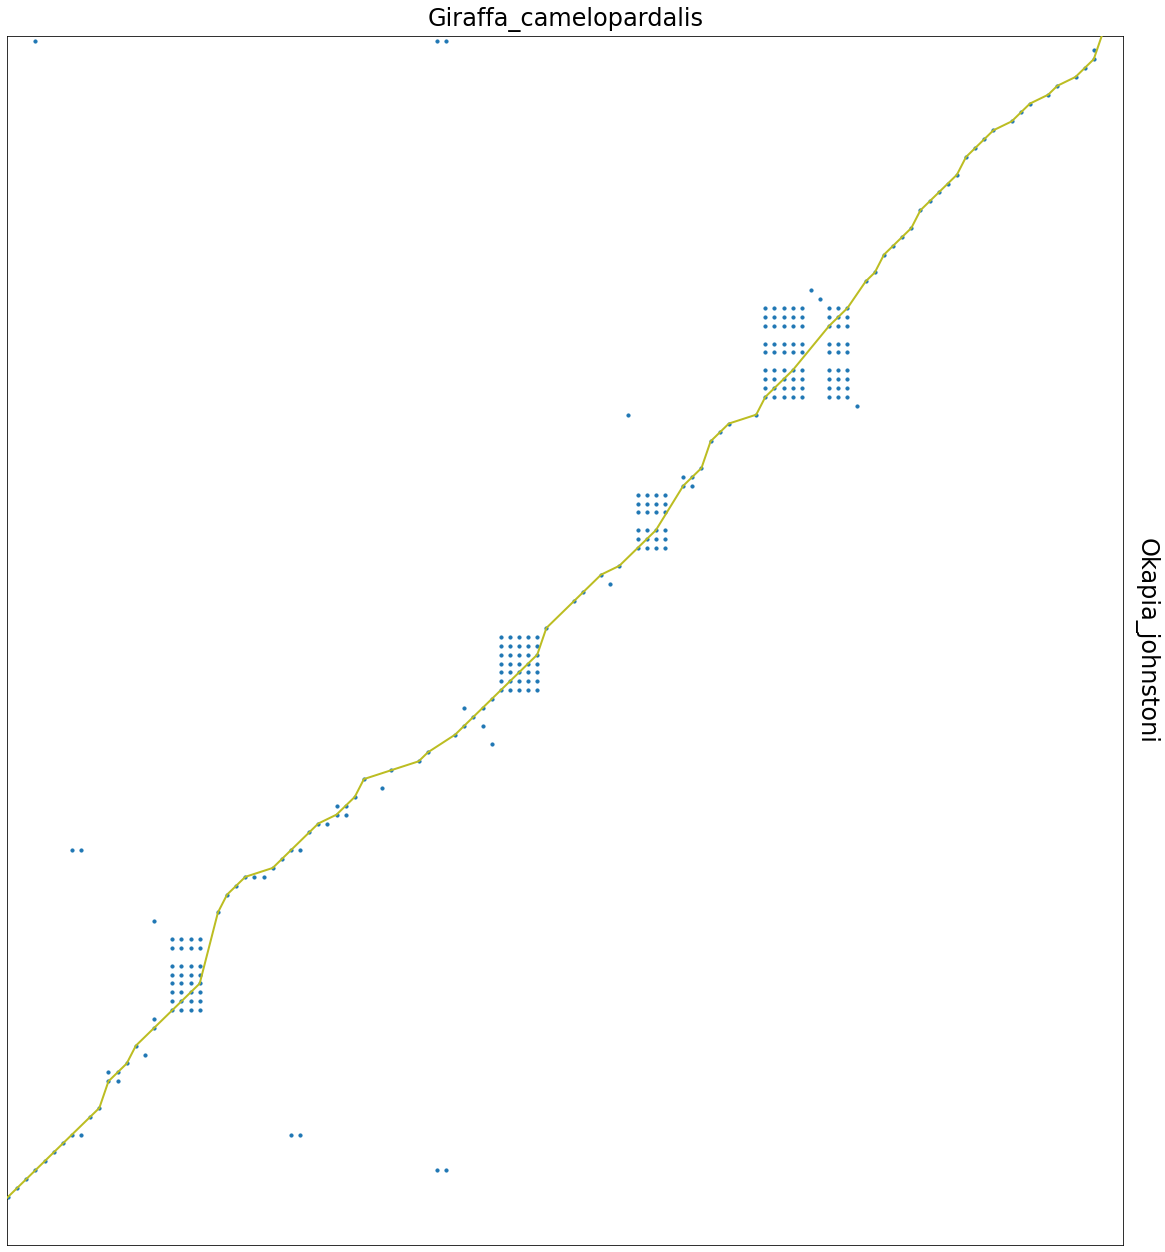

In [16]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=absolute_blocks,xlim=7,ylim=9,dot_size=10,xfrac_lim=[.9,.975],yfrac_lim=[.8,.95],block_color='many',label1=spA,label2=spB)


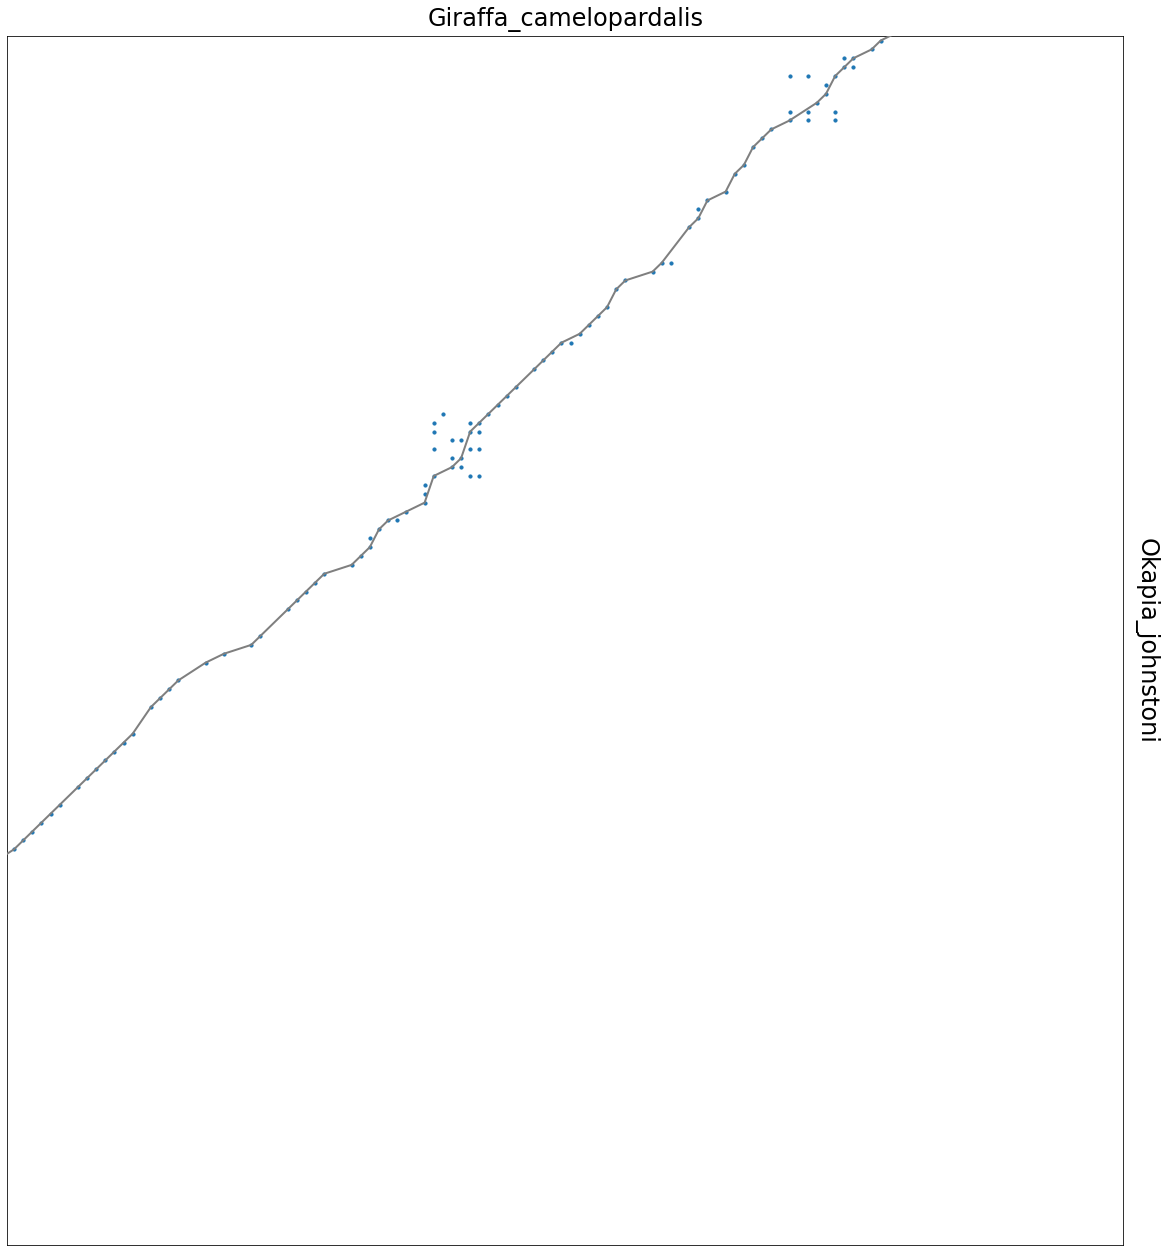

In [17]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=absolute_blocks,xlim=7,ylim=9,dot_size=10,xfrac_lim=[.75,.825],yfrac_lim=[.5,.65],block_color='many',label1=spA,label2=spB)


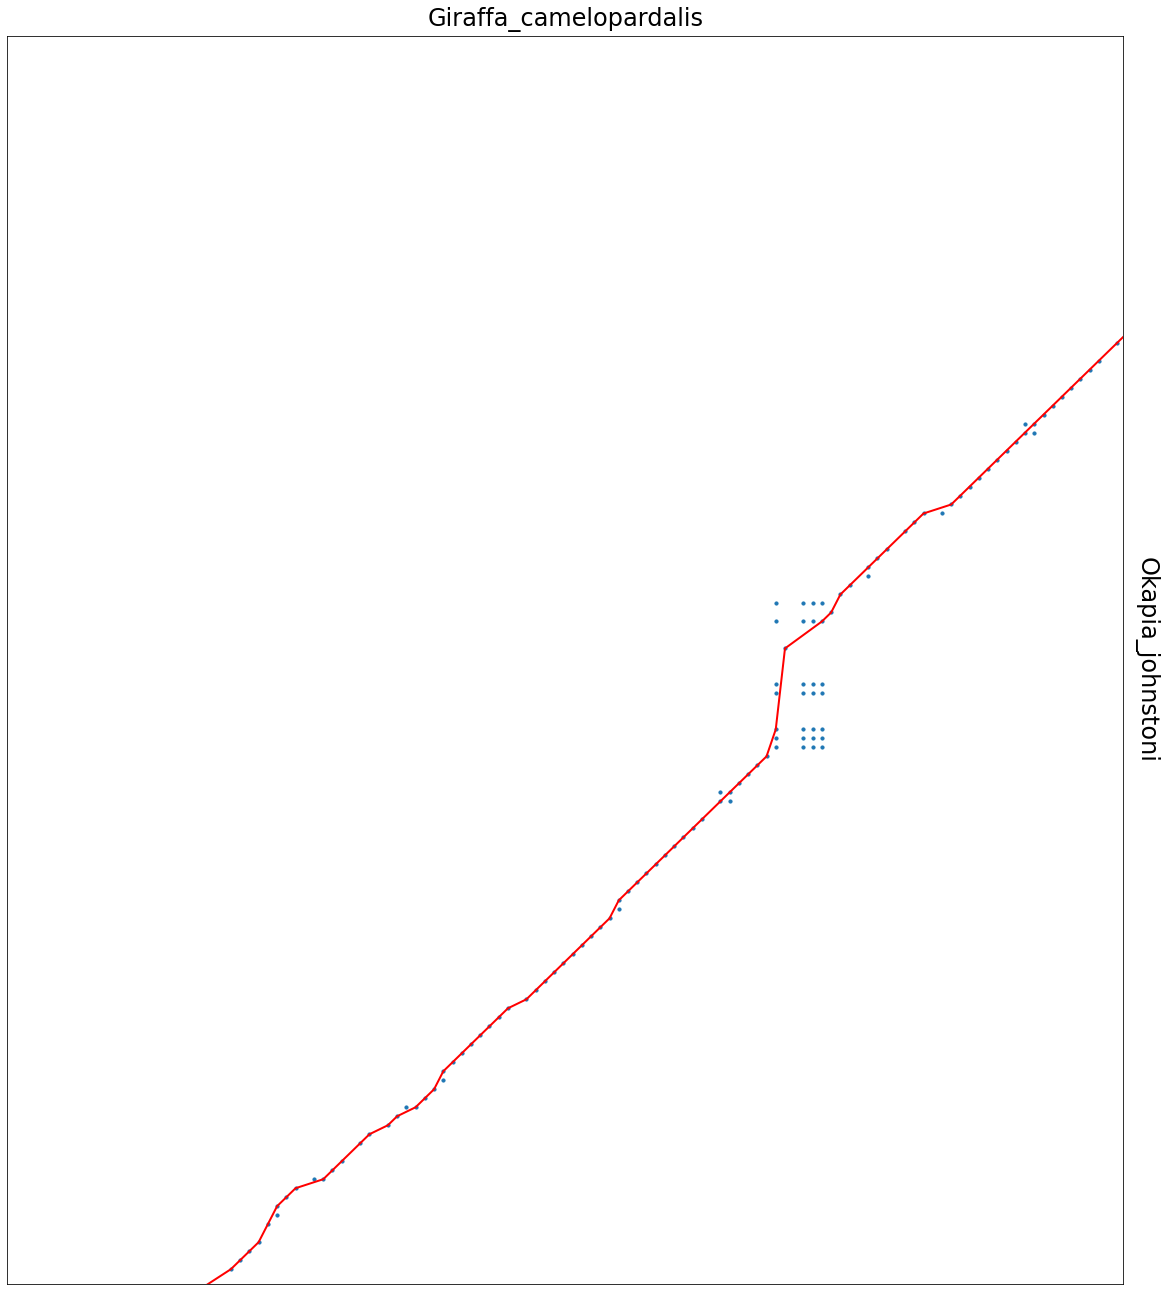

In [18]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=absolute_blocks,xlim=4,ylim=19,xfrac_lim=[.575,.625],yfrac_lim=[.625,.675],dot_size=10,block_color='r',label1=spA,label2=spB)


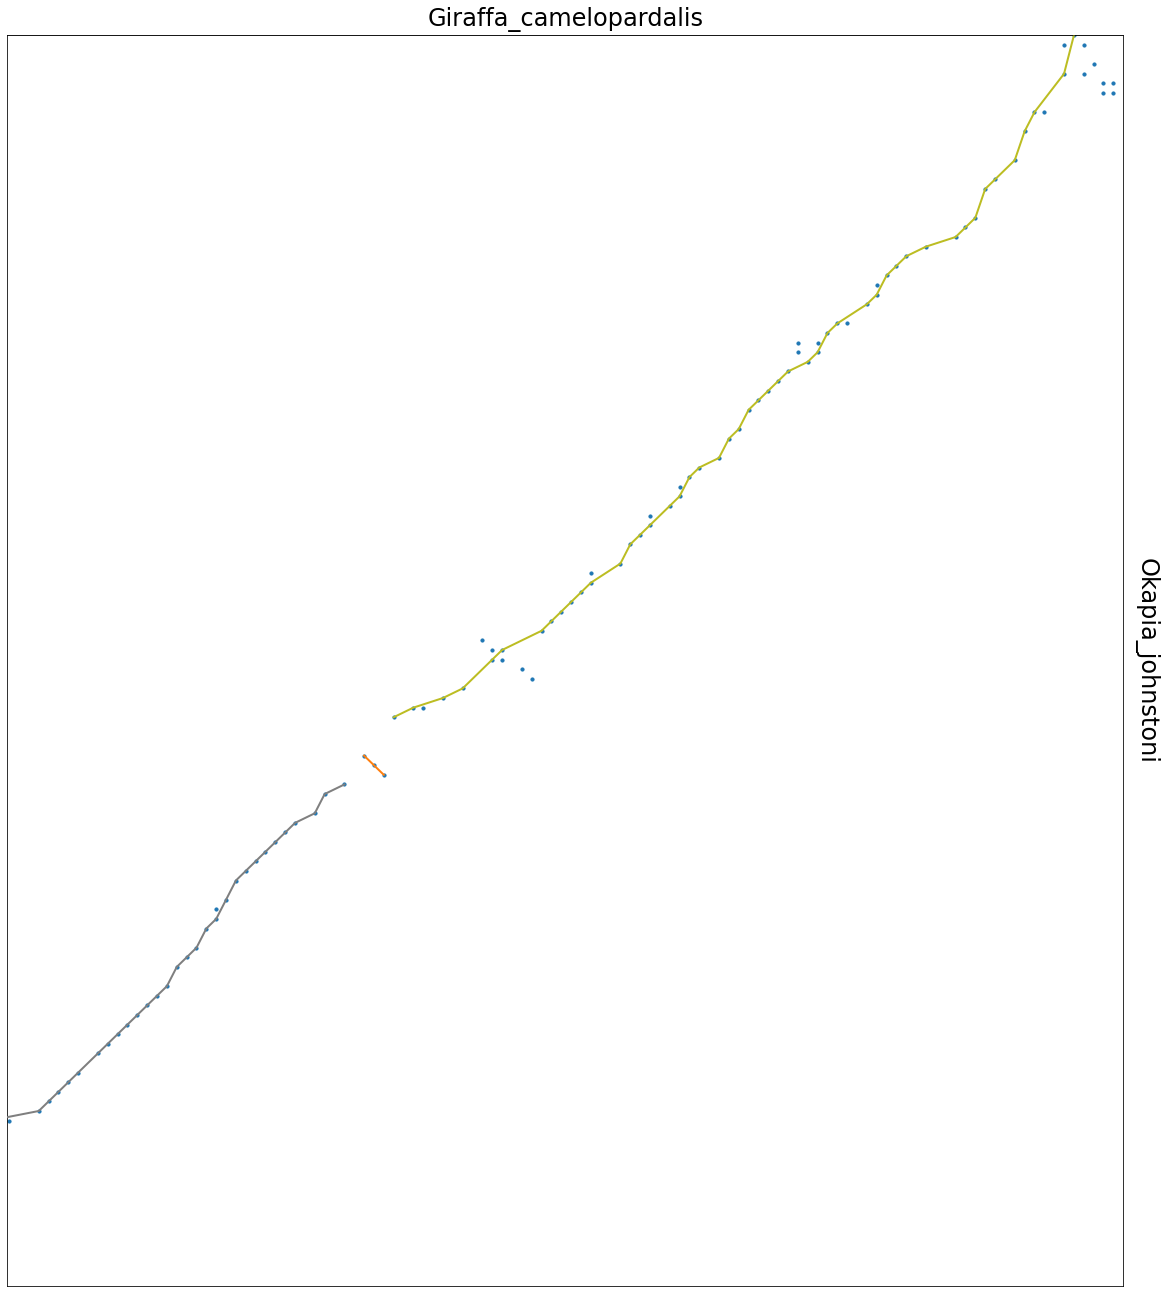

In [19]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=absolute_blocks,xlim=11,ylim=17,xfrac_lim=[.9,1],yfrac_lim=[.8,1],dot_size=10,block_color='many',label1=spA,label2=spB)


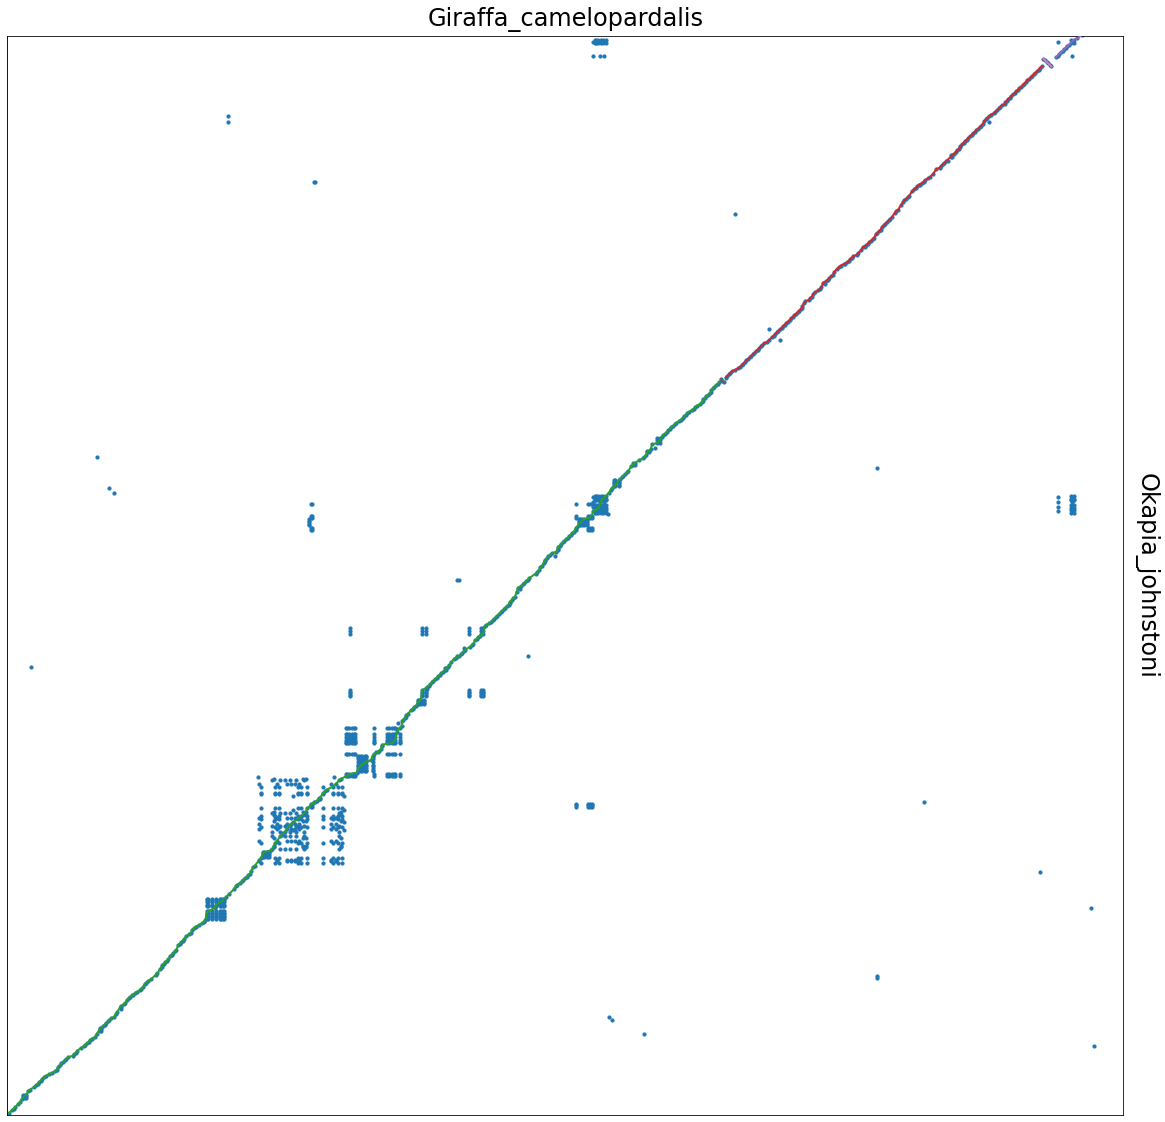

In [20]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=absolute_blocks,xlim=9,ylim=19,xfrac_lim=[0,.5],yfrac_lim=[0,.25],dot_size=10,block_color='many',label1=spA,label2=spB)


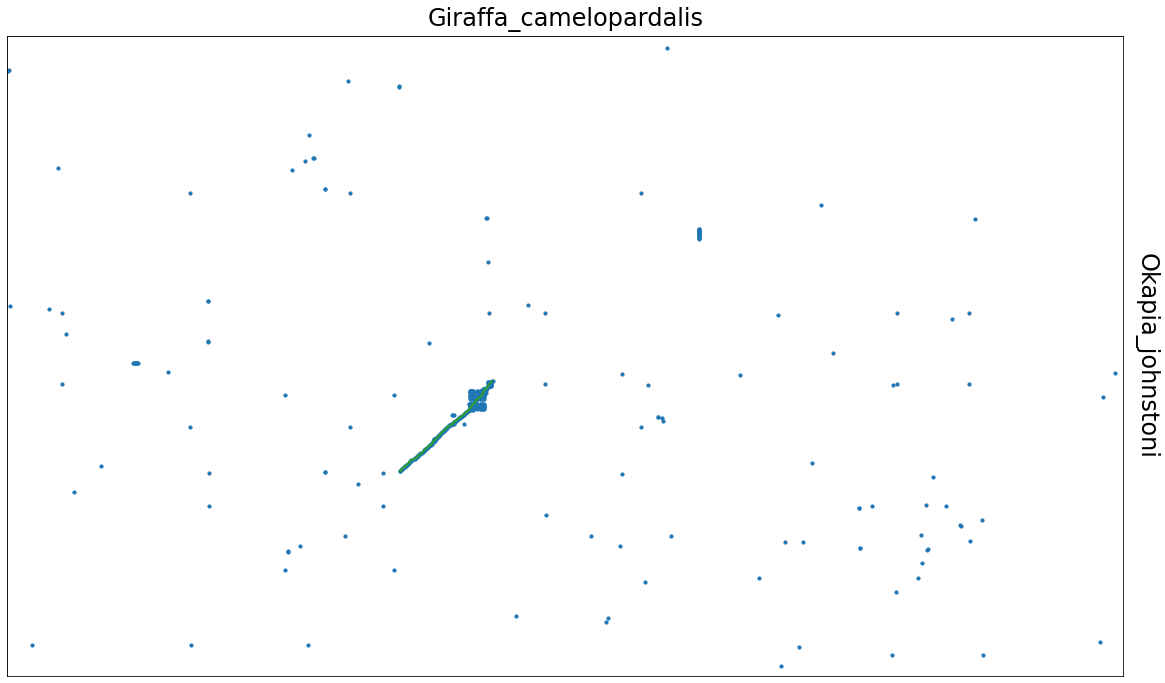

In [21]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=absolute_blocks,xlim=5,ylim=7,xfrac_lim=[0,1],yfrac_lim=[0,1],dot_size=10,block_color='many',label1=spA,label2=spB)


In [22]:
import matplotlib.pyplot as plt

In [23]:
h = np.unique([b.shape[0] for b in absolute_blocks],return_counts=True)

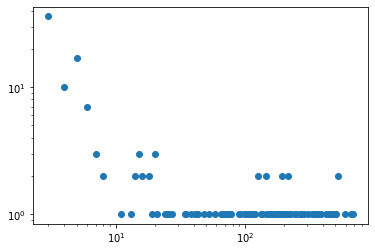

In [24]:
plt.scatter(h[0],h[1])
plt.xscale('log')
plt.yscale('log')

In [24]:
len(absolute_blocks)

181

In [8]:
import gzip
import pickle as pkl
import numpy as np

In [22]:
with open("Giraffa_camelopardalis-Okapia_johnstoni-dotplot.pkl","rb") as f:
    hmat = pkl.load(f)

hmat_lines = []
for chrom_pair in hmat['data'].keys():
    x,y = np.where(hmat['data'][chrom_pair]['homology_matrix'].A.T == 1)
    chromA,chromB = chrom_pair
    out = np.vstack([np.array(x.shape[0]*[chromA]),x+1,np.array(x.shape[0]*[chromB]),y+1]).T
    hmat_lines.append(out)
hmat_lines = np.vstack(hmat_lines)
empty = np.vstack((9-hmat_lines.shape[1])*[np.array(hmat_lines.shape[0]*[''])]).T
hmat_lines = np.hstack([hmat_lines,empty])

save_dot_plot('Giraffa_camelopardalis-Okapia_johnstoni-dotplot.csv','Giraffa_camelopardalis','Okapia_johnstoni',hmat_lines,gzip_file=True)

/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_4247/2406346935.py:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  hmat = pkl.load(f)


In [21]:
with open("Homo_sapiens-Mus_musculus-dotplot.pkl","rb") as f:
    hmat = pkl.load(f)

hmat_lines = []
for chrom_pair in hmat['data'].keys():
    x,y = np.where(hmat['data'][chrom_pair]['homology_matrix'].A.T == 1)
    chromA,chromB = chrom_pair
    out = np.vstack([np.array(x.shape[0]*[chromA]),x+1,np.array(x.shape[0]*[chromB]),y+1]).T
    hmat_lines.append(out)
hmat_lines = np.vstack(hmat_lines)
empty = np.vstack((9-hmat_lines.shape[1])*[np.array(hmat_lines.shape[0]*[''])]).T
hmat_lines = np.hstack([hmat_lines,empty])

save_dot_plot('Homo_sapiens-Mus_musculus-dotplot.csv','Homo_sapiens','Mus_musculus',hmat_lines,gzip_file=True)

/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_4247/2441096726.py:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  hmat = pkl.load(f)


In [20]:
with open("Macaca_fuscata-Mandrillus_sphinx-dotplot.pkl","rb") as f:
    hmat = pkl.load(f)

hmat_lines = []
for chrom_pair in hmat['data'].keys():
    x,y = np.where(hmat['data'][chrom_pair]['homology_matrix'].A.T == 1)
    chromA,chromB = chrom_pair
    out = np.vstack([np.array(x.shape[0]*[chromA]),x+1,np.array(x.shape[0]*[chromB]),y+1]).T
    hmat_lines.append(out)
hmat_lines = np.vstack(hmat_lines)
empty = np.vstack((9-hmat_lines.shape[1])*[np.array(hmat_lines.shape[0]*[''])]).T
hmat_lines = np.hstack([hmat_lines,empty])

save_dot_plot('Macaca_fuscata-Mandrillus_sphinx-dotplot.csv','Macaca_fuscata','Mandrillus_sphinx',hmat_lines,gzip_file=True)

/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_4247/415673002.py:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  hmat = pkl.load(f)


In [12]:
with open("Okapia_johnstoni-ASM166083v1_HiC-orthogroup_assignments.pkl","rb") as f:
    spdat = pkl.load(f)

spdat_list = []
n_tot = 0
for nc, chrom in enumerate(alphanum_sort(list(spdat.keys()))):
    N = spdat[chrom]['gene_names'].shape[0]
    chrom_name = np.array(N*[chrom])
    chrom_num = np.array(N*[nc+1])
    relative_index = np.arange(1,N+1)
    absolute_index = n_tot + relative_index
    orthogroup = spdat[chrom]['ogs']
    gene_name = spdat[chrom]['gene_names']
    gene_label = spdat[chrom]['gene_labels']
    empty = np.array(N*[''])
    sppdat_chrom = np.vstack([chrom_name,chrom_num,relative_index,absolute_index,orthogroup,gene_name,gene_label,empty,empty,empty,empty,empty])
    spdat_list.append(sppdat_chrom.T)
    n_tot += N    
spdat_arr = np.vstack(spdat_list)

save_species_data('Okapia_johnstoni_species_data.csv','Okapia_johnstoni',spdat_arr,labels=species_data_labels_A,gzip_file=True)

In [13]:
with open("Giraffa_camelopardalis-ASM165123v1_HiC-orthogroup_assignments.pkl","rb") as f:
    spdat = pkl.load(f)

spdat_list = []
n_tot = 0
for nc, chrom in enumerate(alphanum_sort(list(spdat.keys()))):
    N = spdat[chrom]['gene_names'].shape[0]
    chrom_name = np.array(N*[chrom])
    chrom_num = np.array(N*[nc+1])
    relative_index = np.arange(1,N+1)
    absolute_index = n_tot + relative_index
    orthogroup = spdat[chrom]['ogs']
    gene_name = spdat[chrom]['gene_names']
    gene_label = spdat[chrom]['gene_labels']
    empty = np.array(N*[''])
    sppdat_chrom = np.vstack([chrom_name,chrom_num,relative_index,absolute_index,orthogroup,gene_name,gene_label,empty,empty,empty,empty,empty])
    spdat_list.append(sppdat_chrom.T)
    n_tot += N    
spdat_arr = np.vstack(spdat_list)

save_species_data('Giraffa_camelopardalis_species_data.csv','Giraffa_camelopardalis',spdat_arr,labels=species_data_labels_A,gzip_file=True)

In [14]:
with open("Homo_sapiens-gencode-orthogroup_assignments.pkl","rb") as f:
    spdat = pkl.load(f)

spdat_list = []
n_tot = 0
for nc, chrom in enumerate(alphanum_sort(list(spdat.keys()))):
    N = spdat[chrom]['gene_names'].shape[0]
    chrom_name = np.array(N*[chrom])
    chrom_num = np.array(N*[nc+1])
    relative_index = np.arange(1,N+1)
    absolute_index = n_tot + relative_index
    orthogroup = spdat[chrom]['ogs']
    gene_name = spdat[chrom]['gene_names']
    gene_label = spdat[chrom]['gene_labels']
    empty = np.array(N*[''])
    sppdat_chrom = np.vstack([chrom_name,chrom_num,relative_index,absolute_index,orthogroup,gene_name,gene_label,empty,empty,empty,empty,empty])
    spdat_list.append(sppdat_chrom.T)
    n_tot += N    
spdat_arr = np.vstack(spdat_list)

save_species_data('Homo_sapiens_species_data.csv','Homo_sapiens',spdat_arr,labels=species_data_labels_A,gzip_file=True)

In [15]:
with open("Mus_musculus-gencode-orthogroup_assignments.pkl","rb") as f:
    spdat = pkl.load(f)

spdat_list = []
n_tot = 0
for nc, chrom in enumerate(alphanum_sort(list(spdat.keys()))):
    N = spdat[chrom]['gene_names'].shape[0]
    chrom_name = np.array(N*[chrom])
    chrom_num = np.array(N*[nc+1])
    relative_index = np.arange(1,N+1)
    absolute_index = n_tot + relative_index
    orthogroup = spdat[chrom]['ogs']
    gene_name = spdat[chrom]['gene_names']
    gene_label = spdat[chrom]['gene_labels']
    empty = np.array(N*[''])
    sppdat_chrom = np.vstack([chrom_name,chrom_num,relative_index,absolute_index,orthogroup,gene_name,gene_label,empty,empty,empty,empty,empty])
    spdat_list.append(sppdat_chrom.T)
    n_tot += N    
spdat_arr = np.vstack(spdat_list)

save_species_data('Mus_musculus_species_data.csv','Mus_musculus',spdat_arr,labels=species_data_labels_A,gzip_file=True)

In [16]:
with open("Macaca_fuscata-Macaca_fuscata_HiC-orthogroup_assignments.pkl","rb") as f:
    spdat = pkl.load(f)

spdat_list = []
n_tot = 0
for nc, chrom in enumerate(alphanum_sort(list(spdat.keys()))):
    N = spdat[chrom]['gene_names'].shape[0]
    chrom_name = np.array(N*[chrom])
    chrom_num = np.array(N*[nc+1])
    relative_index = np.arange(1,N+1)
    absolute_index = n_tot + relative_index
    orthogroup = spdat[chrom]['ogs']
    gene_name = spdat[chrom]['gene_names']
    gene_label = spdat[chrom]['gene_labels']
    empty = np.array(N*[''])
    sppdat_chrom = np.vstack([chrom_name,chrom_num,relative_index,absolute_index,orthogroup,gene_name,gene_label,empty,empty,empty,empty,empty])
    spdat_list.append(sppdat_chrom.T)
    n_tot += N    
spdat_arr = np.vstack(spdat_list)

save_species_data('Macaca_fuscata_species_data.csv','Macaca_fuscata',spdat_arr,labels=species_data_labels_A,gzip_file=True)

In [17]:
with open("Mandrillus_sphinx-BGI_mandrill_1-orthogroup_assignments.pkl","rb") as f:
    spdat = pkl.load(f)

spdat_list = []
n_tot = 0
for nc, chrom in enumerate(alphanum_sort(list(spdat.keys()))):
    N = spdat[chrom]['gene_names'].shape[0]
    chrom_name = np.array(N*[chrom])
    chrom_num = np.array(N*[nc+1])
    relative_index = np.arange(1,N+1)
    absolute_index = n_tot + relative_index
    orthogroup = spdat[chrom]['ogs']
    gene_name = spdat[chrom]['gene_names']
    gene_label = spdat[chrom]['gene_labels']
    empty = np.array(N*[''])
    sppdat_chrom = np.vstack([chrom_name,chrom_num,relative_index,absolute_index,orthogroup,gene_name,gene_label,empty,empty,empty,empty,empty])
    spdat_list.append(sppdat_chrom.T)
    n_tot += N    
spdat_arr = np.vstack(spdat_list)

save_species_data('Mandrillus_sphinx_species_data.csv','Mandrillus_sphinx',spdat_arr,labels=species_data_labels_A,gzip_file=True)